# Análise do jogo político utilizando [Dados Abertos](http://dadosabertos.camara.leg.br)

![dados abertos](images/dados-abertos.png)

## Objetivos

### => Extrair informações de votações da API de Dados Abertos utilizando a linguagem Python
### => Preparar os dados para análise com a biblioteca Pandas
### => Visualizar o posicionamento político utilizando algoritmos de redução de dimensionalidade
### => Aplicar aprendizado não supervisionado para analizar a coesão partidária
### => Identificar aplicações potenciais dos dados de votação da API de Dados Abertos
<br/><br/>

## Problema: Como entender objetivamente a dinâmica política?
![plenario](images/motivacao1.jpg)
![plenario](images/motivacao2.png)
![plenario](images/motivacao3.png)

### Estudo de referência: [Data Mining in Politics](http://www.stat.columbia.edu/~jakulin/Politics/) (EUA)

![Data Mining in Politics](images/politics-votes-us.png)

### Vantagens da análise por parlamentar
* Possibilita análise de apenas uma proposição
* Independe do número de partidos (permite comparar com os EUA, por exemplo)
* Responde à questão: Quantos e quais são os "reais" partidos?
* Permite analisar a coesão partidária

## Extração de informações de proposições da [API de Dados Abertos](https://dadosabertos.camara.leg.br/swagger/api.html)

### O que é uma proposição?

Segundo o Art. 100 do Regimento Interno da Câmara dos Deputados:
![proposicao](images/proposicao.png)

### Entidades envolvidas

![entidades](images/entidades.png)

### Implementação das classes

In [1]:
import pandas as pd

class Votante:
    
    def __init__(self, id):
        self.id = id
        self.votos = {}
        
    def add_voto(self, voto, votacao):
        
        if self.votos is None:
            self.votos = {}
        
        self.votos[votacao.id] = voto
    
    def __repr__(self):
        return '%s - %s' % (self.id, self.votos)
    
    
class Deputado(Votante):
    
    def __init__(self, id):
        super(Deputado, self).__init__(id)
        self.nome = ''
        self.partido = ''        
    
    def __repr__(self):
        return "%s - %s - %s" % (self.nome, self.partido, self.votos)
    
    
class Bancada(Votante):
    
    def __init__(self, id):
        super(Bancada, self).__init__(id)
        self.sigla = ''
    
    def __repr__(self):
        return "Bancada_%s - %s" % (self.sigla, self.votos)


class Votacao:
    
    def __init__(self, id):
        self.id = id
        self.objeto = None
        self.data = None
        self.hora = None
        self.resumo = None
        
    def __repr__(self):
        return '%s - %s' % (self.id, self.resumo)

    
class Proposicao:
    
    def __init__(self, xml_root=None):
        
        self.votantes = {}
        self.votacoes = {}
        
        if xml:
            self.parse_xml(xml_root)
            
        else:
            self.votantes = {}
            self.sigla = None
            self.numero = None
            self.ano = None
    
    def __get_votante(self, id, tipo):
    
        if id in self.votantes:
            return self.votantes[id]

        elif tipo == 'Deputado':
            votante = Deputado(id)

        elif tipo == 'bancada':
            votante = Bancada(id)

        else:
            votante = Votante(id)

        self.votantes[id] = votante
        return votante
    
    def __get_votacao(self, id):
        
        if id in self.votacoes:
            return self.votacoes[id]
        else:
            votacao = Votacao(id)
        self.votacoes[id] = votacao
        return votacao
    
    def parse_xml(self, xml_root):
        
        for proposicao in xml_root:        
            #print(prop.tag, prop.attrib)
            
            if proposicao.tag == 'Sigla':
                self.sigla = proposicao.text
                
            if proposicao.tag == 'Numero':
                self.numero = proposicao.text
                
            if proposicao.tag == 'Ano':
                self.ano = proposicao.text
                
            for votacao in proposicao:
                #print(votacao.tag, votacao.text)
                _votacao = self.__get_votacao(votacao.attrib['ObjVotacao'])
                _votacao.cod_sessao = votacao.attrib['codSessao']
                _votacao.objeto = votacao.attrib['ObjVotacao']
                _votacao.data = votacao.attrib['Data']
                _votacao.hora = votacao.attrib['Hora']
                _votacao.resumo = votacao.attrib['Resumo']
                
                for tipos_votacao in votacao:
                    #print(tipos_votacao.tag, tipos_votacao.text)

                    for voto in tipos_votacao:

                        if voto.tag == 'Deputado':
                            votante = self.__get_votante(voto.attrib['ideCadastro'], voto.tag)
                            votante.nome = voto.attrib['Nome'].strip()
                            votante.partido = voto.attrib['Partido'].strip()
                            votante.uf = voto.attrib['UF'].strip()
                            votante.add_voto(voto.attrib['Voto'].strip(), _votacao)
                        else:
                            votante = self.__get_votante(voto.attrib['Sigla'], voto.tag)
                            votante.sigla = voto.attrib['Sigla'].strip()
                            votante.add_voto(voto.attrib['orientacao'].strip(), _votacao)
                            
    def to_dataframe(self):
        
        votos = pd.DataFrame()

        for i, votante in self.votantes.items():

            if isinstance(votante, Deputado):
                row = {'nome': votante.nome, 'partido': votante.partido, 'uf': votante.uf}
            else:
                row = {'nome': 'Bancada_' + votante.sigla, 'partido': votante.sigla, 'uf': 'BR'}
            
            for j, votacao in proposicao.votacoes.items():
                row[votacao.id] = votante.votos.get(votacao.id)

            votos = votos.append(row, ignore_index=True)
                
        return votos
    
    def __repr__(self):
        return '%s - %s/%s (%d votações; %d votantes)' % (self.sigla, self.numero, self.ano, 
                                                          len(self.votacoes), len(self.votantes))

### Consultando web service do Dados Abertos

In [2]:
import xml.etree.ElementTree
import urllib.request as req

def get_url_proposicao(tipo, numero, ano):
    url = 'http://www.camara.leg.br/SitCamaraWS/Proposicoes.asmx/ObterVotacaoProposicao?tipo=%s&numero=%s&ano=%s'
    return url % (tipo, numero, ano)

def get_resource(url):    
    file = req.urlopen(url)
    return file

def get_proposicao(tipo, numero, ano):
    url = get_url_proposicao(tipo, numero, ano)
    file = get_resource(url)
    xml_root = xml.etree.ElementTree.parse(file).getroot()
    return Proposicao(xml_root)
    
#root = xml.etree.ElementTree.parse('votacao.xml').getroot()

### Estudo de caso: Projeto de Lei 6787 de 2016

In [3]:
url = get_url_proposicao('PL', 6787, 2016)
url

'http://www.camara.leg.br/SitCamaraWS/Proposicoes.asmx/ObterVotacaoProposicao?tipo=PL&numero=6787&ano=2016'

In [4]:
proposicao = get_proposicao('PL', 6787, 2016)
proposicao

PL - 6787/2016 (8 votações; 538 votantes)

### Votações relacionadas

In [20]:
for v in proposicao.votacoes:
    print(v)

REQUERIMENTO DE RETIRADA DE PAUTA
REQUERIMENTO DE VOTAÇÃO NOMINAL DO REQ. DE RETIRADA DE PAUTA
SUBEMENDA SUBSTITUTIVA GLOBAL
DTQ 2  - PDT - ART. 442-B, CONST. DO ART. 1º DO SUBSTITUTIVO
REQUERIMENTO DE ENCERRAMENTO DA DISCUSSÃO E DO ENCAMINHAMENTO
DTQ 18 - PSOL- ART. 611-A, CONST.  DO ART. 1º DO SUBSTITUTIVO
DTQ 54 - PT - EMENDA DE PLENÁRIO Nº 15
DTQ 51 - SD - EMENDA DE PLENÁRIO Nº 28


## Preparação dos dados
O primeiro passo é transformar os dados em um dataframe da biblioteca ```pandas```.

In [6]:
votos = proposicao.to_dataframe()
print(votos.shape)
votos.head()

(538, 11)


,"DTQ 18 - PSOL- ART. 611-A, CONST. DO ART. 1º DO SUBSTITUTIVO","DTQ 2 - PDT - ART. 442-B, CONST. DO ART. 1º DO SUBSTITUTIVO",DTQ 51 - SD - EMENDA DE PLENÁRIO Nº 28,DTQ 54 - PT - EMENDA DE PLENÁRIO Nº 15,REQUERIMENTO DE ENCERRAMENTO DA DISCUSSÃO E DO ENCAMINHAMENTO,REQUERIMENTO DE RETIRADA DE PAUTA,REQUERIMENTO DE VOTAÇÃO NOMINAL DO REQ. DE RETIRADA DE PAUTA,SUBEMENDA SUBSTITUTIVA GLOBAL,nome,partido,uf
0,Sim,Sim,Não,Não,Sim,Sim,Não,Sim,Bancada_PpPtnPTdoB,PpPtnPTdoB,BR
1,Sim,Sim,Não,Não,Sim,Não,Não,Sim,Bancada_PMDB,PMDB,BR
2,Não,Não,Sim,Sim,Não,Obstrução,Obstrução,Não,Bancada_PT,PT,BR
3,Sim,Sim,Não,Não,Sim,Não,Não,Sim,Bancada_PSDB,PSDB,BR
4,Sim,Sim,Não,Não,Sim,Não,Não,Sim,Bancada_PR,PR,BR


### O "vetor político"
Cada sequência de votos forma um vetor de posicionamento político em relação ao conjunto de proposições.

In [7]:
import numpy as np
np.random.seed(23)
# criando um vetor político aleatório
vetor_politico = np.random.choice(['Sim', 'Não', 'Obstrução'], size=votos.shape[1]-3, p=[2/5, 2/5, 1/5])
vetor_politico

array(['Não', 'Obstrução', 'Não', 'Sim', 'Sim', 'Não', 'Sim', 'Sim'], 
      dtype='<U9')

Vamos adicionar um novo votante no conjunto de dados para comparar o seus posicionamento com os outros votantes.

In [8]:
row = {'nome': 'Campuseiro', 'partido': 'Campus Party', 'uf': 'DF'}

for i, key in enumerate(proposicao.votacoes):
    row[proposicao.votacoes[key].id] = vetor_politico[i]

votos = votos.append(row, ignore_index=True)
print(votos.shape)
votos.tail()

(539, 11)


,"DTQ 18 - PSOL- ART. 611-A, CONST. DO ART. 1º DO SUBSTITUTIVO","DTQ 2 - PDT - ART. 442-B, CONST. DO ART. 1º DO SUBSTITUTIVO",DTQ 51 - SD - EMENDA DE PLENÁRIO Nº 28,DTQ 54 - PT - EMENDA DE PLENÁRIO Nº 15,REQUERIMENTO DE ENCERRAMENTO DA DISCUSSÃO E DO ENCAMINHAMENTO,REQUERIMENTO DE RETIRADA DE PAUTA,REQUERIMENTO DE VOTAÇÃO NOMINAL DO REQ. DE RETIRADA DE PAUTA,SUBEMENDA SUBSTITUTIVA GLOBAL,nome,partido,uf
534,-,-,-,-,Sim,Não,Não,Sim,Rômulo Gouveia,PSD,PB
535,Sim,Sim,Não,-,-,-,-,Sim,André Amaral,PMDB,PB
536,Sim,Não,Sim,Não,Sim,-,None,Sim,Ronaldo Nogueira,PTB,RS
537,Não,Não,Sim,Sim,Não,Obstrução,None,Não,Deoclides Macedo,PDT,MA
538,Não,Sim,Sim,Sim,Sim,Não,Obstrução,Não,Campuseiro,Campus Party,DF


### Tratando variáveis categóricas
É necessário transformar os valores "Sim", "Não", "Abstenção" em valores numéricos. Uma das maneiras de fazer isso é transformar as linhas em [one-hot vectors](https://www.quora.com/What-is-one-hot-encoding-and-when-is-it-used-in-data-science), utilizando a função ```pandas.get_dummies```.

![one hot encoding](images/one-hot.png)

In [9]:
features = votos.columns.drop(['uf', 'nome', 'partido']).tolist()
features_df = pd.get_dummies(votos[features])

votos = pd.concat([votos[['nome', 'uf', 'partido']], features_df], axis=1)
print(votos.shape)
votos.head()

(539, 50)


,nome,uf,partido,"DTQ 18 - PSOL- ART. 611-A, CONST. DO ART. 1º DO SUBSTITUTIVO_-","DTQ 18 - PSOL- ART. 611-A, CONST. DO ART. 1º DO SUBSTITUTIVO_Abstenção","DTQ 18 - PSOL- ART. 611-A, CONST. DO ART. 1º DO SUBSTITUTIVO_Art. 17","DTQ 18 - PSOL- ART. 611-A, CONST. DO ART. 1º DO SUBSTITUTIVO_Não","DTQ 18 - PSOL- ART. 611-A, CONST. DO ART. 1º DO SUBSTITUTIVO_Sim","DTQ 2 - PDT - ART. 442-B, CONST. DO ART. 1º DO SUBSTITUTIVO_-","DTQ 2 - PDT - ART. 442-B, CONST. DO ART. 1º DO SUBSTITUTIVO_Abstenção",...,REQUERIMENTO DE VOTAÇÃO NOMINAL DO REQ. DE RETIRADA DE PAUTA_Art. 17,REQUERIMENTO DE VOTAÇÃO NOMINAL DO REQ. DE RETIRADA DE PAUTA_Liberado,REQUERIMENTO DE VOTAÇÃO NOMINAL DO REQ. DE RETIRADA DE PAUTA_Não,REQUERIMENTO DE VOTAÇÃO NOMINAL DO REQ. DE RETIRADA DE PAUTA_Obstrução,REQUERIMENTO DE VOTAÇÃO NOMINAL DO REQ. DE RETIRADA DE PAUTA_Sim,SUBEMENDA SUBSTITUTIVA GLOBAL_-,SUBEMENDA SUBSTITUTIVA GLOBAL_Art. 17,SUBEMENDA SUBSTITUTIVA GLOBAL_Liberado,SUBEMENDA SUBSTITUTIVA GLOBAL_Não,SUBEMENDA SUBSTITUTIVA GLOBAL_Sim
0,Bancada_PpPtnPTdoB,BR,PpPtnPTdoB,0,0,0,0,1,0,0,...,0,0,1,0,0,0,0,0,0,1
1,Bancada_PMDB,BR,PMDB,0,0,0,0,1,0,0,...,0,0,1,0,0,0,0,0,0,1
2,Bancada_PT,BR,PT,0,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,1,0
3,Bancada_PSDB,BR,PSDB,0,0,0,0,1,0,0,...,0,0,1,0,0,0,0,0,0,1
4,Bancada_PR,BR,PR,0,0,0,0,1,0,0,...,0,0,1,0,0,0,0,0,0,1


## Visualização e interpretação dos dados

### Calculando matriz de distâncias entre "vetores políticos"
Cada linha da tabela de votos corresponde a um "vetor político". Assim, podemos utilizar métricas de distância entre vetores para montar uma matriz de distâncias. A biblioteca ```scipy``` oferece [diversas opções para o cálculo de distância entre vetores](https://docs.scipy.org/doc/scipy/reference/spatial.distance.html).
![vector distance](images/vector-distance.jpg)

In [10]:
import scipy.spatial.distance

def pairwise_distances(data, metric='dice'):
    dists = scipy.spatial.distance.pdist(data, metric)
    return scipy.spatial.distance.squareform(dists)

features = votos.columns.drop(['uf', 'nome', 'partido']).tolist()
votos.sort_values(['partido', 'uf'], inplace=True)
dists = pairwise_distances(votos[features].values)

print(dists.shape)
dists

(539, 539)


array([[ 0.   ,  0.625,  0.875, ...,  0.5  ,  0.5  ,  0.625],
       [ 0.625,  0.   ,  0.25 , ...,  0.125,  1.   ,  0.625],
       [ 0.875,  0.25 ,  0.   , ...,  0.375,  0.875,  0.625],
       ..., 
       [ 0.5  ,  0.125,  0.375, ...,  0.   ,  0.875,  0.5  ],
       [ 0.5  ,  1.   ,  0.875, ...,  0.875,  0.   ,  0.5  ],
       [ 0.625,  0.625,  0.625, ...,  0.5  ,  0.5  ,  0.   ]])

### Visualizando a matriz de distâncias

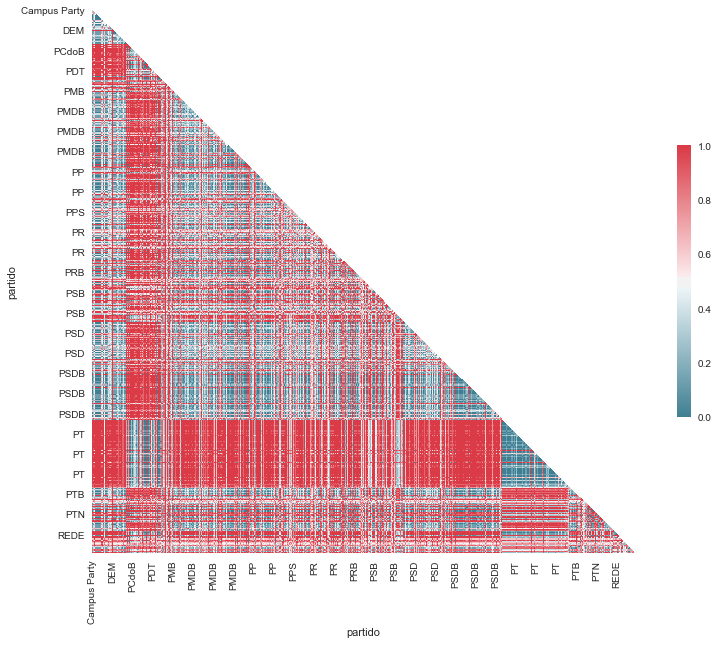

In [21]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline


def plot_distances(distances, labels, ticklabels=True):
    
    sns.set(style="white")

    # Generate a large random dataset
    rs = np.random.RandomState(33)
    dists_df = pd.DataFrame(data=distances, columns=labels, index=labels)

    # Generate a mask for the upper triangle
    mask = np.zeros_like(dists_df, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(15, 10))

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(dists_df, mask=mask, cmap=cmap, #vmax=.3,
                square=True, xticklabels=ticklabels, yticklabels=ticklabels,
                cbar_kws={"shrink": .5}, ax=ax)

votos.sort_values(['partido', 'uf'], inplace=True)
dists = pairwise_distances(votos[features].values)
plot_distances(dists, votos.partido, ticklabels=20)

### Cenário político: Brasil x EUA

![Brasil x EUA](images/politics-matrix-comp.png)

### Agregando votos por partido

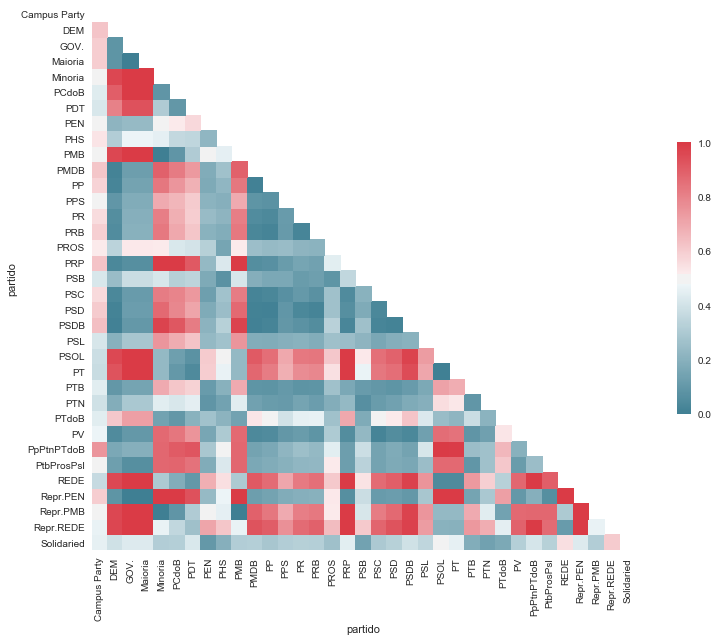

In [12]:
votos_partido = votos.groupby('partido').mean()
dists = pairwise_distances(votos_partido.values, metric='cosine')
plot_distances(dists, votos_partido.index)

### Principal Component Analysis ([PCA](https://en.wikipedia.org/wiki/Principal_component_analysis))

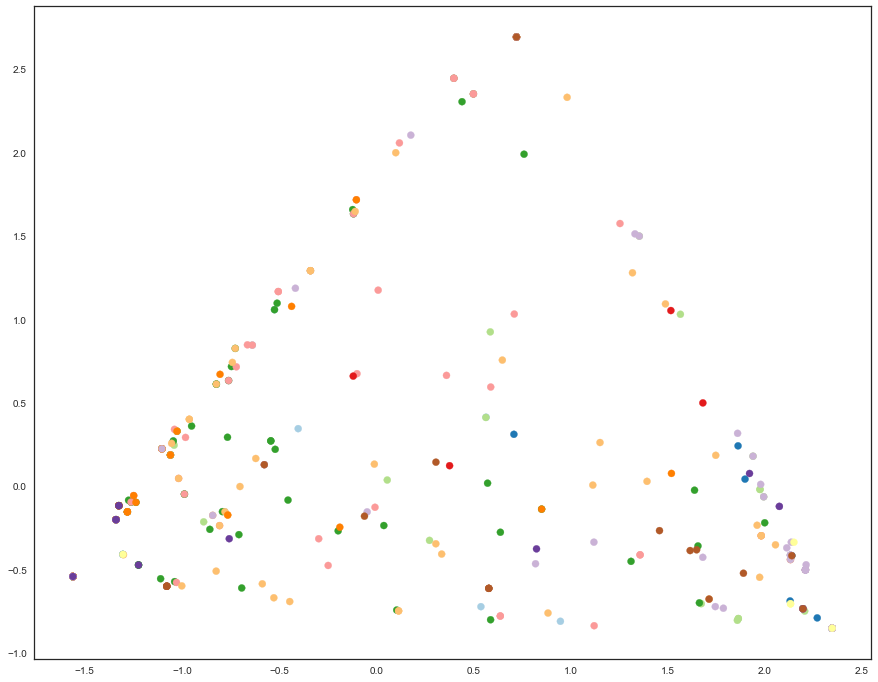

In [16]:
from sklearn.decomposition import PCA
from sklearn import preprocessing

le = preprocessing.LabelEncoder()
labels = le.fit_transform(votos['partido'])

X_pca = PCA(n_components=2).fit_transform(votos[features])

plt.figure(figsize=(15, 12))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, s=50, cmap=plt.cm.Paired)

### t-Distributed Stochastic Neighbor Embedding (t-SNE)

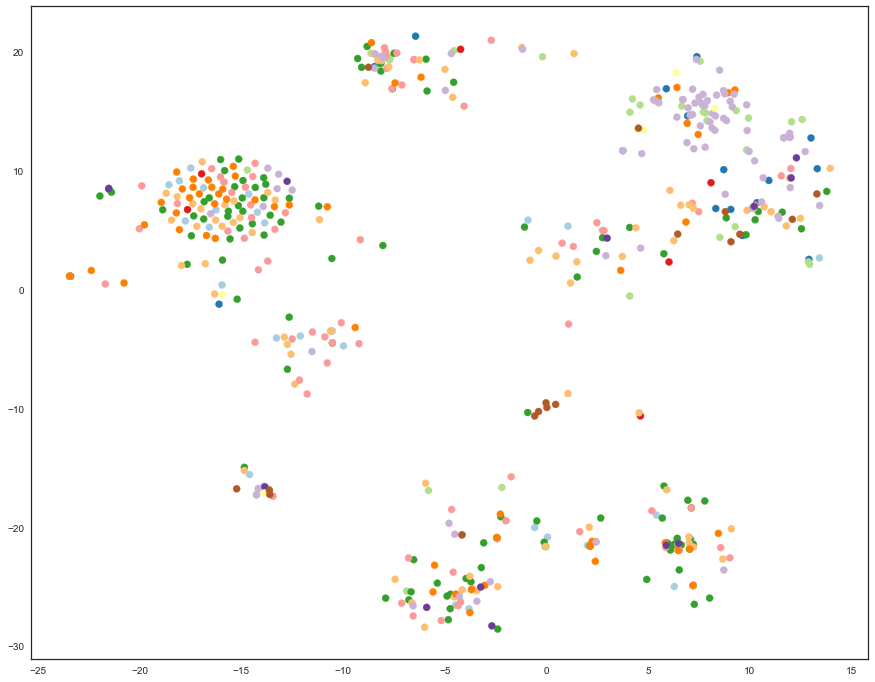

In [14]:
from sklearn.manifold import TSNE
from sklearn import preprocessing

le = preprocessing.LabelEncoder()
labels = le.fit_transform(votos['partido'])

features = votos.columns.drop(['uf', 'nome', 'partido']).tolist()
X_tsne = TSNE(random_state=17, n_iter=2000, perplexity=50).fit_transform(votos[features])

plt.figure(figsize=(15, 12))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=labels, s=50, cmap=plt.cm.Paired)

### Ferramenta: Embedding Projector
Gerando arquivos para visualização no [Embedding Projector](http://projector.tensorflow.org).

In [22]:
pd.DataFrame(votos[features]).to_csv('data/votos.tsv', sep='\t', index=False, header=False)
pd.DataFrame(votos[['nome', 'partido', 'uf']]).to_csv('data/votos_meta.tsv', sep='\t', index=False, encoding='utf-8')

## Clusterização: medindo a coesão partidária

Vamos identificar os *clusters* políticos com o algoritmo [K-means da biblioteca scikit-learn](http://scikit-learn.org/stable/modules/clustering.html#k-means).

![kmeans](images/kmeans.png)

In [19]:
from sklearn.cluster import KMeans

#somente_partidos = [~votos.nome.str.startswith('Bancada')]
kmeans_model = KMeans(n_clusters=5, random_state=1).fit(votos[features])

labels = kmeans_model.labels_

clusters = pd.crosstab(votos["partido"], labels)
# removendo partidos com apenas 1 representante
clusters = clusters[clusters.sum(axis=1) > 1]
print(clusters.shape)
clusters

(24, 5)


col_0,0,1,2,3,4
partido,,,,,
DEM,20,0,3,6,2
PCdoB,0,4,2,0,7
PDT,1,14,6,0,0
PEN,1,0,0,1,1
PHS,1,0,1,2,4
PMDB,35,0,7,18,5
PP,26,0,6,9,6
PPS,5,0,0,3,2
PR,17,0,11,7,5


### Coesão = percentual de votantes concentrados no cluster mais significativo

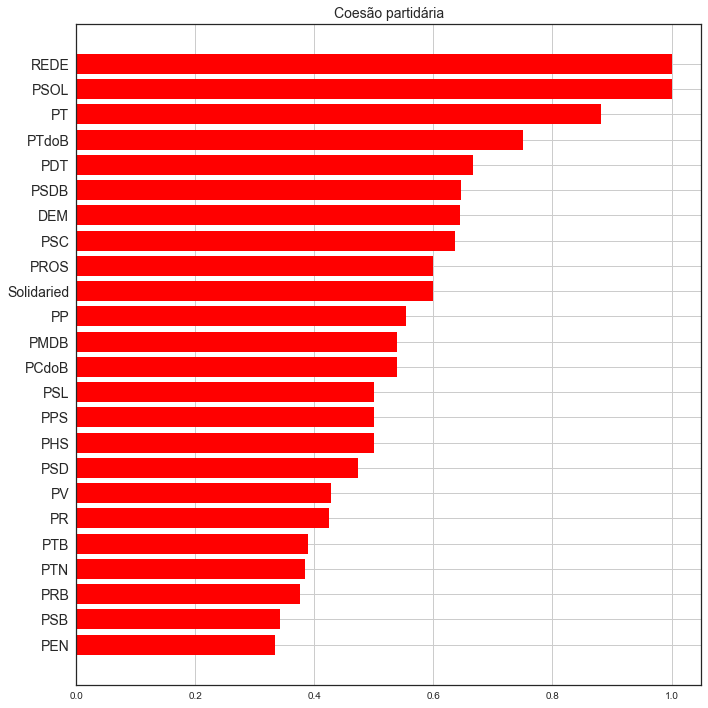

In [34]:
def coesao(clusters):
    return np.max(clusters)/np.sum(clusters)

coesao_partidos = clusters.apply(lambda x: coesao(x), axis=1).sort_values(ascending=True)

# plot coesao
fig = plt.figure(figsize=(10,10))
plt.title("Coesão partidária", fontsize=14)
y_range = [i for i in range(len(coesao_partidos))]
plt.barh(y_range, coesao_partidos,
         color="r", align="center")
plt.yticks(y_range,
           coesao_partidos.index, fontsize=14)
plt.grid()
plt.tight_layout()

## Próximos passos / desafios
* Implementar um sistema de recomendação de parlamentares com base no "vetor político"
* Seria possível justificar estatísticamente uma diminuição no número de partidos?
* Detectar anomalias no posicionamento político
* Correlacionar votações com variáveis macroeconômicas (câmbio, taxa de juros, etc)

### Exemplos interessantes
* [GovTrack (EUA)](https://www.govtrack.us/about/analysis)
* [Radar Parlamentar](http://radarparlamentar.polignu.org/)
* [Atlas Político](http://www.atlaspolitico.com.br)

![transforma](images/def-transforma.png)